<a href="https://colab.research.google.com/github/Ananduak7/A-HYBRID-MULTI-MODEL-BASED-APPROACH-FOR-HEART-DISEASE-DETECTION-AND-CLASSIFICATION/blob/main/HEART_1_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install librosa


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split

Feature Extraction:

Loads .wav files using librosa.
Extracts Mel-Frequency Cepstral Coefficients (MFCCs), a popular feature in speech and biomedical signal processing.
Pads or truncates MFCCs to ensure consistent input size.
Data Preparation:

Splits data into training and testing sets.
Reshapes features for LSTM processing.
Model Training:

Uses a Bi-LSTM model for sequential pattern learning.
Applies dropout for regularization.
Uses binary cross-entropy loss for classification.
Resources for Learning
Audio Preprocessing & Feature Extraction

Librosa Documentation
YouTube: Audio Processing in Python
Deep Learning for Heart Sound Classification

Keras LSTM Guide
YouTube: Bi-LSTM for Sequence Learning
PhysioNet Challenge Dataset

Official PhysioNet 2016
This approach combines audio signal processing with NLP-inspired models to detect heart diseases efficiently. Let me know if you need modifications or improvements!

In [ ]:
# Provide your train and test dataset paths here
TRAIN_HEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/healthy"  # Replace with your train/healthy folder path
TRAIN_UNHEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy"  # Replace with your train/unhealthy folder path
TEST_HEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/val/healthy"  # Replace with your test/healthy folder path
TEST_UNHEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/val/unhealthy"  # Replace with your test/unhealthy folder path


# Define labels
LABELS = {"healthy": 0, "unhealthy": 1}

In [ ]:
# Function to extract MFCC features from a wav file
def extract_features(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
# Function to load data from train or test folder
def load_data(healthy_path, unhealthy_path):
    features, labels = [], []

    # Load healthy data
    healthy_files = glob(os.path.join(healthy_path, "*.wav"))
    for file_path in healthy_files:
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(LABELS["healthy"])

    # Load unhealthy data
    unhealthy_files = glob(os.path.join(unhealthy_path, "*.wav"))
    for file_path in unhealthy_files:
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(LABELS["unhealthy"])

    return np.array(features), np.array(labels)

In [ ]:
# Load train and test data
X_train, y_train = load_data(TRAIN_HEALTHY_PATH, TRAIN_UNHEALTHY_PATH)
X_test, y_test = load_data(TEST_HEALTHY_PATH, TEST_UNHEALTHY_PATH)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3240, 40, 400)
y_train shape: (3240,)
X_test shape: (301, 40, 400)
y_test shape: (301,)


In [ ]:
# Further split test into validation (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)


In [ ]:
# Reshape for LSTM input (samples, time steps, features, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


In [ ]:
# Build the Bi-LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(40, 400))),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Reshape for LSTM input (samples, time steps, features) - Removing the channels dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

# Build the Bi-LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))), # Using the correct input shape
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.7969 - loss: 0.4591 - val_accuracy: 0.7086 - val_loss: 0.5565
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.8962 - loss: 0.2799 - val_accuracy: 0.7351 - val_loss: 0.5087
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9040 - loss: 0.2321 - val_accuracy: 0.7947 - val_loss: 0.4197
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9311 - loss: 0.1787 - val_accuracy: 0.8411 - val_loss: 0.3019
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.9520 - loss: 0.1335 - val_accuracy: 0.8609 - val_loss: 0.2916
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9587 - loss: 0.0976 - val_accuracy: 0.8940 - val_loss: 0.2168
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.9718 - loss: 0.0775 - val_accuracy: 0.9470 - val_loss: 0.1431
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9851 - loss: 0

In [ ]:
model.save("SOUND_LSTM_model.h5")


In [ ]:
# Save X_test and y_test
np.save('/content/X_test.npy', X_test)
np.save('/content/y_test.npy', y_test)


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9572 - loss: 0.1183
Test Accuracy: 0.96


In [ ]:
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9858
Validation Accuracy: 0.9868
Test Accuracy: 0.9600


In [ ]:
train_loss, model_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Model Accuracy (Training Accuracy): {model_accuracy:.4f}")


Model Accuracy (Training Accuracy): 0.9858


In [ ]:
val_loss, model_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Model Accuracy (Validation Accuracy): {model_accuracy:.4f}")


Model Accuracy (Validation Accuracy): 0.9868


In [ ]:
#Detection code
import numpy as np
import librosa
import tensorflow as tf

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Function to preprocess a new audio file for prediction
def preprocess_audio(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)  # Load audio file with librosa
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract MFCC features

        # Padding or truncating to ensure consistent input length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Reshape to match the model input shape (1 sample, time steps, features, channels)
        mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to make prediction
def detect_heart_disease(file_path):
    # Preprocess the audio file
    features = preprocess_audio(file_path)
    if features is None:
        print("Error in preprocessing the audio file.")
        return

    # Make prediction using the model
    prediction = model.predict(features)

    # Convert prediction to class label (0 = Healthy, 1 = Unhealthy)
    predicted_class = 1 if prediction[0] > 0.5 else 0  # Threshold at 0.5 for binary classification
    print(f"Predicted Class: {LABELS[predicted_class]}")

# Example usage
#NEW_AUDIO_FILE = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/healthy/a0007.wav"  # Replace with the path to your new .wav file
NEW_AUDIO_FILE="/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy/a0005.wav"
detect_heart_disease(NEW_AUDIO_FILE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
Predicted Class: Unhealthy


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Function to preprocess a new audio file for prediction
def preprocess_audio(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)  # Load audio file with librosa
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract MFCC features

        # Padding or truncating to ensure consistent input length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Reshape to match the model input shape (1 sample, time steps, features, channels)
        mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to make prediction
def detect_heart_disease(file_path):
    # Preprocess the audio file
    features = preprocess_audio(file_path)
    if features is None:
        print("Error in preprocessing the audio file.")
        return

    # Make prediction using the model
    prediction = model.predict(features)

    # Convert prediction to class label (0 = Healthy, 1 = Unhealthy)
    predicted_class = 1 if prediction[0] > 0.5 else 0  # Threshold at 0.5 for binary classification
    print(f"Predicted Class: {LABELS[predicted_class]}")
    return predicted_class

# Evaluate the model on test set and generate confusion matrix
def evaluate_model(X_test, y_test):
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class, target_names=["Healthy", "Unhealthy"]))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred_class

# Plot model accuracy and loss curves
def plot_metrics(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
NEW_AUDIO_FILE = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy/a0005.wav"  # Replace with the path to your new .wav file
predicted_class = detect_heart_disease(NEW_AUDIO_FILE)

# Load model history for plotting (ensure that model training includes the history)
# Uncomment this after training the model and saving the history
# plot_metrics(history)

# Evaluate model (use your actual test data `X_test`, `y_test` here)
# Assuming you have X_test and y_test from your dataset:
# y_pred_class = evaluate_model(X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Unhealthy


In [ ]:
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_17 (Bidirectional)     │ (None, 40, 128)             │         238,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,411 (1.07 MB)

 Trainable params: 281,409 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Confusion Matrix:
[[69  6]
 [ 0 75]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.92      0.96        75
   Unhealthy       0.93      1.00      0.96        75

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



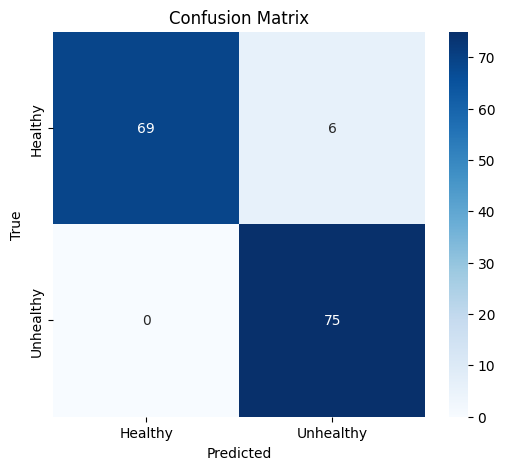

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Evaluate the model on test set and generate confusion matrix
def evaluate_model(X_test, y_test):
    # Predict on the test data
    y_pred = model.predict(X_test, verbose=0)  # verbose=0 to suppress retracing warnings
    y_pred_class = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class, target_names=["Healthy", "Unhealthy"]))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred_class

# Assuming you have X_test and y_test from your dataset:
# You need to have these arrays from your original dataset

# Example:
# X_test, y_test = ...  # Load or prepare your test data here

# Evaluate the model
evaluate_model(X_test, y_test)


Classification Report:

              precision    recall  f1-score   support

     Healthy       1.00      0.92      0.96        75
   Unhealthy       0.93      1.00      0.96        75

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



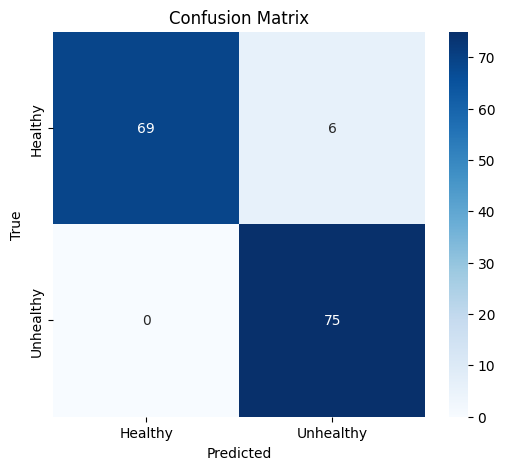

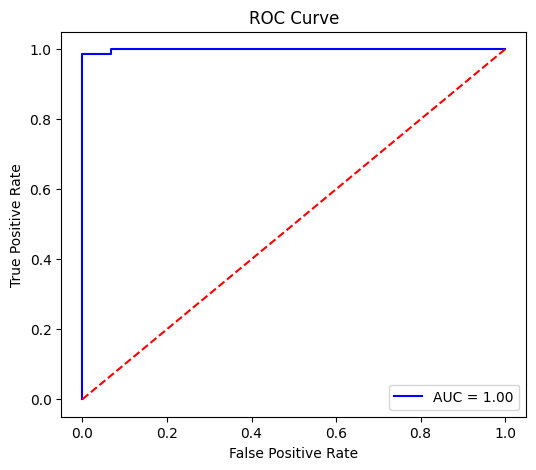

AUC Score: 1.00


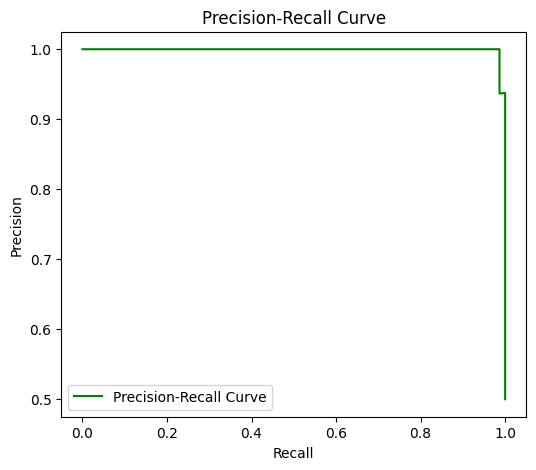

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Evaluate the model on test set and generate various metrics
def evaluate_model(X_test, y_test):
    # Predict on the test data
    y_pred_probs = model.predict(X_test, verbose=0)  # Probability scores
    y_pred_class = (y_pred_probs > 0.5).astype(int)  # Convert to class labels

    # Accuracy, Precision, Recall, F1-score
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_class, target_names=["Healthy", "Unhealthy"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve & AUC Score
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print(f"AUC Score: {roc_auc:.2f}")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return y_pred_class, y_pred_probs

# Accuracy & Loss Graphs from training history
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

# Example usage:
# Ensure `history` is available if you trained the model in the same session
# plot_metrics(history)

# Evaluate model (use your actual test data `X_test`, `y_test`)
y_pred_class, y_pred_probs = evaluate_model(X_test, y_test)


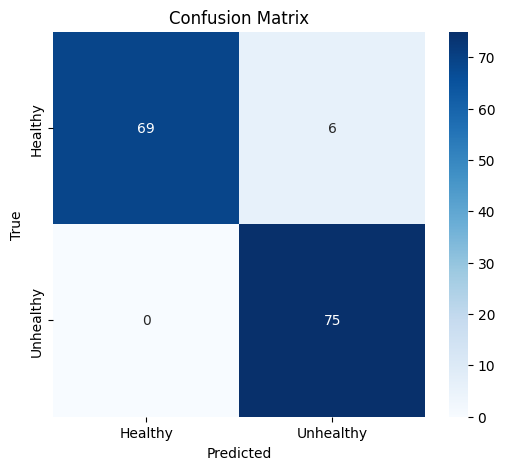

Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      0.92      0.96        75
   Unhealthy       0.93      1.00      0.96        75

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



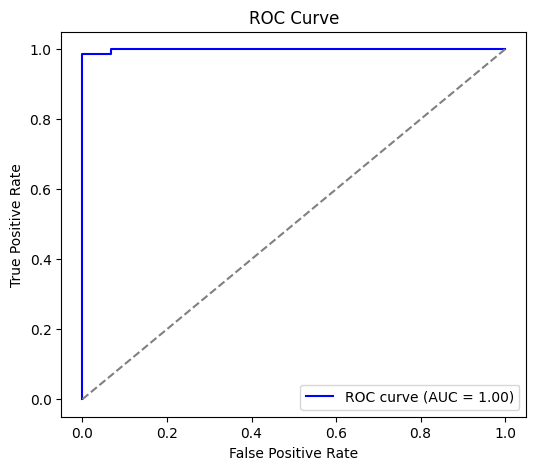

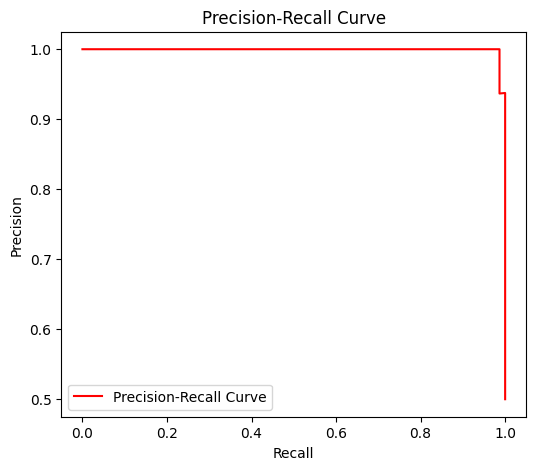

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model path
model = tf.keras.models.load_model(MODEL_PATH)

# Load test dataset
X_test = np.load('/content/X_test.npy')
y_test = np.load('/content/y_test.npy')

# Predict on test data
y_pred_probs = model.predict(X_test, verbose=0)  # Get probability scores
y_pred_class = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary classes

# 1️⃣ **Confusion Matrix**
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 2️⃣ **Classification Report**
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=["Healthy", "Unhealthy"])
    print("Classification Report:\n", report)

# 3️⃣ **ROC Curve & AUC Score**
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# 4️⃣ **Precision-Recall Curve**
def plot_precision_recall_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='red', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# 5️⃣ **Model Accuracy & Loss Curves**
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 🎯 **Execute all evaluation metrics**
plot_confusion_matrix(y_test, y_pred_class)
print_classification_report(y_test, y_pred_class)
plot_roc_curve(y_test, y_pred_probs)
plot_precision_recall_curve(y_test, y_pred_probs)

# Uncomment the next line after training to visualize accuracy and loss curves
# plot_metrics(history)


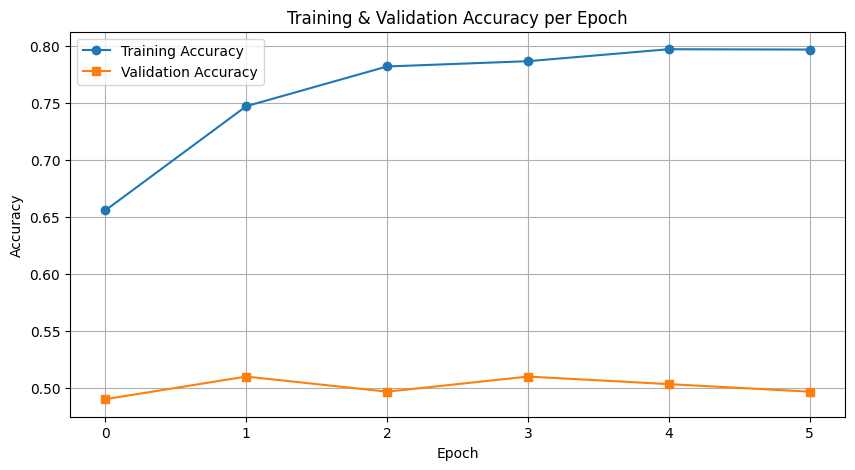

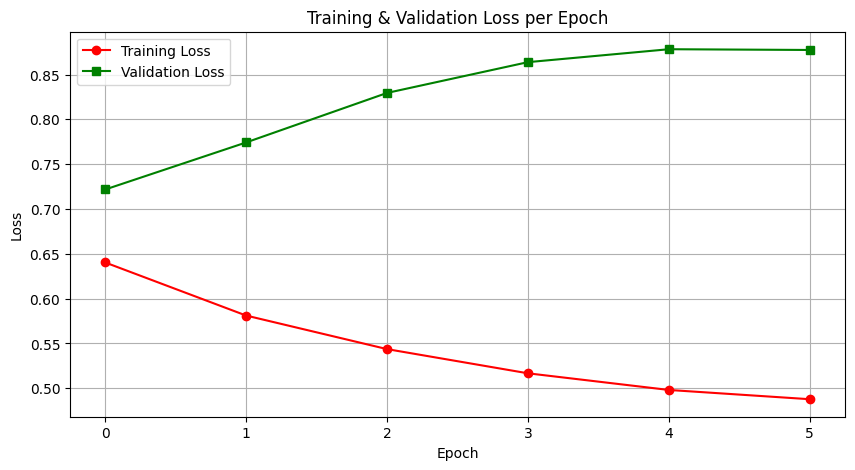

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


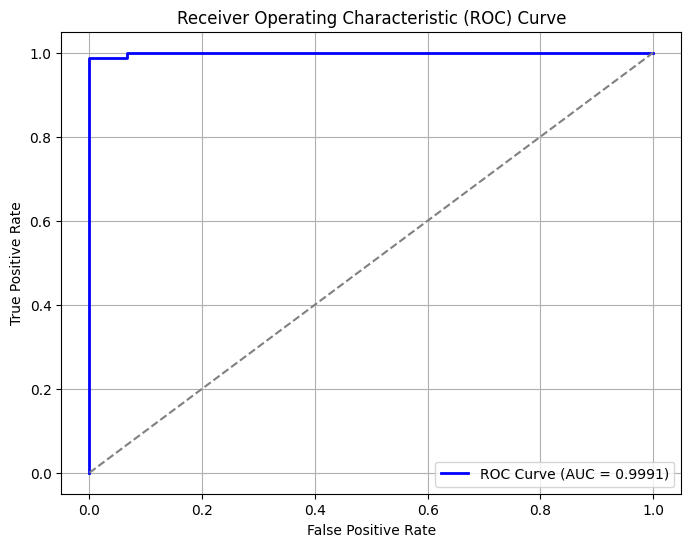

AUC Score: 0.9991


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get model predictions (probabilities)
y_pred_probs = model.predict(X_test)  # Predict probabilities

# Compute FPR (False Positive Rate), TPR (True Positive Rate), and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute AUC Score
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")
